<p><img src="https://www.carkeekwatershed.org/wp-content/uploads/CWCAPlogo-1.png" width="213" height="72"></p>

# CWCAP Salmon Survey Analysis
Press run all to create all figures and generate a report

In [99]:
###ENTER SURVEY YEAR###
surveyYear = '2021'

##INITIALIZATION
import matplotlib.pyplot as plt, plotly.express as px, pandas as pd, sys, pytz, io, base64, matplotlib.dates as mdates
from datetime import datetime
currentTimePacific = datetime.now(pytz.timezone('America/Los_Angeles')).strftime('%Y-%m-%d_%H-%M-%S') #cannot use system time due to colab
reportFileName = currentTimePacific + '_salmonReport.html'
surveyURIs = {'2019':'https://five.epicollect.net/api/export/entries/salmon-survey-2019?form_ref=397fba6ecc674b74836efc190840c42d_5d6f454667a28',
              '2020':'https://five.epicollect.net/api/export/entries/salmon-survey-2020?form_ref=f550ab6c4dab44f49bcc33b7c1904be9_5d6f454667a28',
              '2021':'https://five.epicollect.net/api/export/entries/salmon-survey-2021?form_ref=ad5ffedf0a3246a18934e6ec36ed9569_5d6f454667a28'}
salmonURIs = {'2019':'https://five.epicollect.net/api/export/entries/salmon-survey-2019?form_ref=397fba6ecc674b74836efc190840c42d_5d6f509867795',
              '2020':'https://five.epicollect.net/api/export/entries/salmon-survey-2020?form_ref=f550ab6c4dab44f49bcc33b7c1904be9_5d6f509867795',
              '2021':'https://five.epicollect.net/api/export/entries/salmon-survey-2021?form_ref=ad5ffedf0a3246a18934e6ec36ed9569_5d6f509867795'}
IN_COLAB = 'google.colab' in sys.modules

def filterSalmonDf(salmonDf, *filters):
    for filter in filters:
        field, value = filter
        salmonDf = salmonDf.loc[(salmonDf[field] == value)]
    return salmonDf

In [100]:
###REPORT
reportHeader = '<p><img src="https://www.carkeekwatershed.org/wp-content/uploads/CWCAPlogo-1.png" width="213" height="72"></p><p><h2>CWCAP Salmon Survey Report</h2></p><p><h5>generated {}</h5></p>'.format(currentTimePacific)
reportStyling = '''<style>body {
  font-family: Arial, Helvetica, sans-serif;
  border-collapse: collapse;
  width: 100%;
}

table {
    border-collapse:collapse;
    caption-side: bottom;
}

caption {text-align:left;}

td, th {
  border: 1px solid #ddd;
  padding: 8px;
}

tbody tr {text-align: center;}

tr:nth-child(even){background-color: #f2f2f2;}

tr:hover {background-color: #ddd;}

th {
  padding-top: 12px;
  padding-bottom: 12px;
  text-align: center;
  background-color: #15331c;
  color: white;
}</style>'''
    
def addHTMLToReport(html):
    with open(reportFileName, 'a') as f:
      f.write(html)

def initializeReport():
    addHTMLToReport(reportStyling)
    addHTMLToReport(reportHeader)
    
def addFigureToReport():
    IObytes = io.BytesIO()
    plt.savefig(IObytes, format = 'png')
    IObytes.seek(0)
    encodedPlot = base64.b64encode(IObytes.read()).decode("utf-8")
    html = '<img src=\'data:image/png;base64,{}\'>'.format(encodedPlot)
    addHTMLToReport(html)
    
def clearPreviousReports():
    if (not IN_COLAB):
        import os, glob
        from os.path import exists
        for name in glob.glob('*salmonReport.html'):
            print("Previous report file exists. Deleting " + name)
            os.remove(name)
clearPreviousReports()
initializeReport()

Previous report file exists. Deleting 2021-11-23_22-37-53_salmonReport.html


In [108]:
###DATA FETCHING
import requests, json
def getEntries(uri):
    request = requests.get(url = uri  + '&per_page=1000')
    df = pd.DataFrame(pd.json_normalize(request.json()['data']['entries']))
    while request.json()['links']['next'] is not None:
        nextURL = request.json()['links']['next']
        request = requests.get(url = nextURL)
        df = df.append(pd.json_normalize(request.json()['data']['entries']))
    return df

def getCountWithFilters(salmonDf, *filters):
    return filterSalmonDf(salmonDf, *filters).shape[0]

def addStats(survey, salmonDf):
    surveyUUID = survey['ec5_uuid']
    todaySalmonDf = salmonDf[salmonDf['ec5_parent_uuid'] == surveyUUID]
    remnantChum = getCountWithFilters(todaySalmonDf, ('Species', 'Chum'), ('Type', 'Remnant'))
    deadChum = getCountWithFilters(todaySalmonDf, ('Species', 'Chum'), ('Type', 'Dead')) + remnantChum
    remnantCoho = getCountWithFilters(todaySalmonDf, ('Species', 'Coho'), ('Type', 'Remnant'))
    deadCoho = getCountWithFilters(todaySalmonDf, ('Species', 'Coho'), ('Type', 'Dead')) + remnantCoho
    unknownRemnant = getCountWithFilters(todaySalmonDf, ('Species', 'Unknown'), ('Type', 'Remnant'))
    deadUnknown = getCountWithFilters(todaySalmonDf, ('Species', 'Unknown'), ('Type', 'Dead')) + unknownRemnant
    liveChum = getCountWithFilters(todaySalmonDf, ('Species', 'Chum'), ('Type', 'Live'))
    liveCoho = getCountWithFilters(todaySalmonDf, ('Species', 'Coho'), ('Type', 'Live'))
    liveUnknown = getCountWithFilters(todaySalmonDf, ('Species', 'Unknown'), ('Type', 'Live'))
    liveSeaRunCutthroat = getCountWithFilters(todaySalmonDf, ('Species', 'Sea-run Cutthroat'), ('Type', 'Live'))
    liveResidentCutthroat = getCountWithFilters(todaySalmonDf, ('Species', 'Resident Cutthroat'), ('Type', 'Live'))
    liveCutthroat = liveSeaRunCutthroat + liveResidentCutthroat
    remnantSeaRunCutthroat = getCountWithFilters(todaySalmonDf, ('Species', 'Sea-run Cutthroat'), ('Type', 'Remnant'))
    deadSeaRunCutthroat = getCountWithFilters(todaySalmonDf, ('Species', 'Sea-run Cutthroat'), ('Type', 'Dead')) + remnantSeaRunCutthroat
    remnantResidentCutthroat = getCountWithFilters(todaySalmonDf, ('Species', 'Resident Cutthroat'), ('Type', 'Remnant'))
    deadResidentCutthroat = getCountWithFilters(todaySalmonDf, ('Species', 'Resident Cutthroat'), ('Type', 'Dead'))
    deadCutthroat = deadSeaRunCutthroat + deadResidentCutthroat
    redds = getCountWithFilters(todaySalmonDf, ('Type', 'Redd'))
    #totals include sea run cutthroat but not resident or redds
    totalDeadSalmon = deadChum + deadCoho + deadSeaRunCutthroat + deadUnknown
    totalLiveSalmon = liveChum + liveCoho + liveUnknown + liveSeaRunCutthroat
    total = totalDeadSalmon + totalLiveSalmon
    return pd.Series({'Survey Date': pd.Timestamp(survey['Survey_Date']), 'Dead Chum': deadChum, 'Dead Coho': deadCoho, 'Live Chum': liveChum, 'Live Coho': liveCoho, 'Live Cutthroat': liveCutthroat, 'Dead Cutthroat': deadCutthroat, 'Redds': redds, 'Total Dead Salmon' : totalDeadSalmon, 'Total Live Salmon': totalLiveSalmon, 'Total': total})

def getSurveyEntries():
    surveyDfs = {}
    for year in surveyURIs:
        surveyDfs[year] = getEntries(surveyURIs[year])
    return surveyDfs

def getSalmonEntries():
    salmonDfs = {}
    for year in salmonURIs:
        salmonDfs[year] = getEntries(salmonURIs[year])
    return salmonDfs
    
def getStats(surveyDfs, salmonDfs):
    statsDfs = {}
    for year in surveyDfs:
        if not salmonDfs[year].empty:
            statsDfs[year] = surveyDfs[year].apply(addStats, axis=1, args=[salmonDfs[year]]).groupby(['Survey Date']).sum().reset_index() 
            kwargs = {'Dead to Date' : statsDfs[year]['Total Dead Salmon'].cumsum(), 'Dead Chum to Date' : statsDfs[year]['Dead Chum'].cumsum(), 'Dead Coho to Date' : statsDfs[year]['Dead Coho'].cumsum()}
            statsDfs[year] = statsDfs[year].assign(**kwargs)
    return statsDfs

surveyDfs = getSurveyEntries()
salmonDfs = getSalmonEntries()
statsDfs = getStats(surveyDfs, salmonDfs)
salmonDf = salmonDfs[surveyYear]
surveyDf = surveyDfs[surveyYear]
statsDf = statsDfs[surveyYear]

### Survey Stats Table

In [102]:
###TABLES
import IPython.core.display as ip

def displayTable(title, table):
    html = title + table
    display(ip.HTML(html))
    addHTMLToReport(html)
    
def displaySurveyStatsTable():
    title = '<h3>Survey Totals</h3>'
    statsTable = statsDf[['Survey Date', 'Total Live Salmon', 'Total Dead Salmon', 'Live Chum', 'Dead Chum', 'Live Coho', 'Dead Coho', 'Live Cutthroat', 'Dead Cutthroat', 'Redds']].style.format({'Survey Date': "{:%Y-%m-%d}"}).hide_index().set_caption("Note: Total live salmon includes Sea-Run Cutthroat and Unknowns - entries where surveyors were unable to determine the species. Remnants are included in dead counts.").render()
    displayTable(title, statsTable)
    
def getYearlyTotals():
    max = (statsDf['Dead to Date']+statsDf['Total Live Salmon']).max()
    idxmax = (statsDf['Dead to Date']+statsDf['Total Live Salmon']).idxmax()
    yearlySalmonTotal = int(max)
    yearlyChumTotal = int((statsDf['Dead Chum to Date']+statsDf['Live Chum']).max())
    yearlyCohoTotal = int((statsDf['Dead Coho to Date']+statsDf['Live Coho']).max())
    surveyOfCalculation = statsDf.iloc[idxmax]['Survey Date']
    ### DEBUGGING
    #print('Based on total dead count:', int(statsDf.iloc[idxmax]['Dead to Date']), '|', 'plus total live count:', int(statsDf.iloc[idxmax]['Total Live Salmon']))
    return pd.DataFrame({'Salmon': yearlySalmonTotal, 'Chum': yearlyChumTotal, 'Coho': yearlyCohoTotal, 'Based on survey': surveyOfCalculation}, index=[0])
    
def displayYearlyTotalsTable():
    title='<h3>Yearly Totals</h3>'
    yearlyTotals = getYearlyTotals()
    yearlyTotalsTable=yearlyTotals[['Salmon', 'Chum', 'Coho', 'Based on survey']].style.format({'Based on survey': "{:%Y-%m-%d}"}).hide_index().set_caption("Note: Yearly total is the survey date where (day\'s live + dead up to date) is max").render()
    displayTable(title, yearlyTotalsTable)
    
def displayReddsTable():
    mergedDf = pd.merge(salmonDf, surveyDf, how='inner', left_on = 'ec5_parent_uuid', right_on = 'ec5_uuid')
    title = '<h3>Redds by location</h3>'
    reddsTable = filterSalmonDf(mergedDf, ('Type', 'Redd'))[['Stream', 'Distance', 'Survey_Date']].sort_values(by=['Stream', 'Distance']).style.hide_index().render()
    displayTable(title, reddsTable)
    
displaySurveyStatsTable()
displayYearlyTotalsTable()
displayReddsTable()

Survey Date,Total Live Salmon,Total Dead Salmon,Live Chum,Dead Chum,Live Coho,Dead Coho,Live Cutthroat,Dead Cutthroat,Redds
2021-10-23,8,0,6,0,1,0,0,0,0
2021-10-26,33,3,27,0,4,3,1,0,3
2021-10-30,56,15,44,9,1,5,0,0,2
2021-11-02,95,16,91,12,1,4,1,0,14
2021-11-10,471,54,471,44,0,10,1,0,34
2021-11-13,497,46,496,43,1,1,0,0,11
2021-11-16,451,143,447,114,2,29,2,0,39
2021-11-20,287,269,285,263,2,6,1,0,2
2021-11-23,201,164,197,162,2,2,0,0,1


Salmon,Chum,Coho,Based on survey
911,844,62,2021-11-23


Stream,Distance,Survey_Date
Mohlendorph Creek,40,11/16/2021
Piper's Creek,290,11/02/2021
Piper's Creek,460,11/16/2021
Piper's Creek,500,11/02/2021
Piper's Creek,535,11/02/2021
Piper's Creek,550,11/23/2021
Piper's Creek,570,11/13/2021
Piper's Creek,660,11/02/2021
Piper's Creek,690,11/02/2021
Piper's Creek,715,10/26/2021


### Count Plot

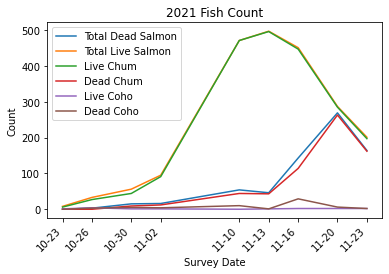

In [103]:
def displayCountPlot(statsDf):
    plot = statsDf.plot(ylabel = 'Count', title = surveyYear + ' Fish Count', rot=45, xticks=statsDf['Survey Date'], y=['Total Dead Salmon', 'Total Live Salmon', 'Live Chum', 'Dead Chum', 'Live Coho', 'Dead Coho'], x='Survey Date')
    plot.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))
    addFigureToReport()
displayCountPlot(statsDf)

### Scatter Map

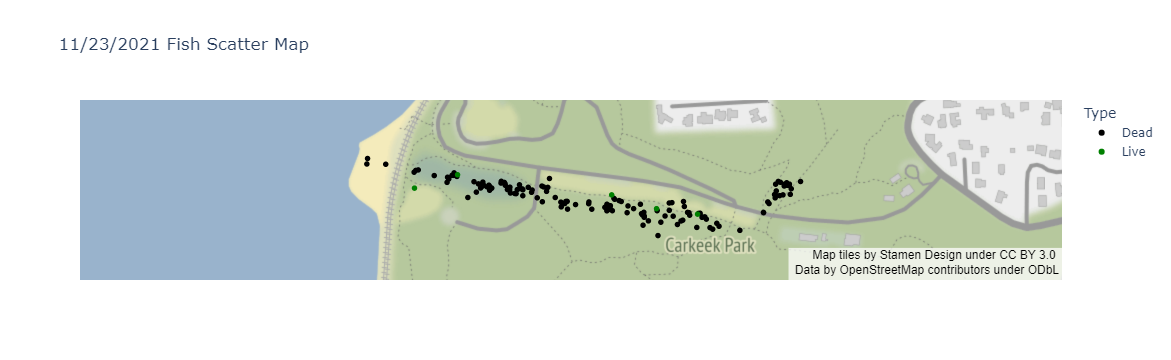

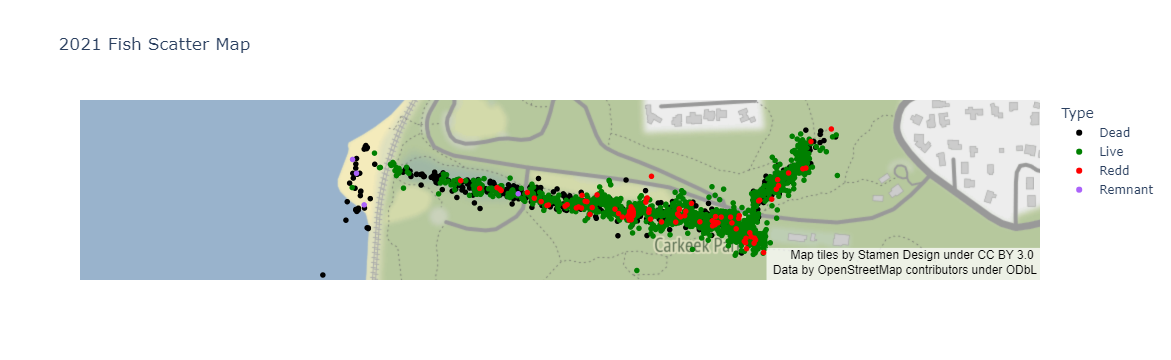

In [104]:
def displayScatterMap(salmonDf, figureTitle):    
    fig = px.scatter_mapbox(salmonDf, lat='Location.latitude', lon='Location.longitude', color='Type', labels={'Type':'Type'}, color_discrete_map={'Live': 'green', 'Redd': 'red', 'Dead': 'black'},
                        center=dict(lat=47.71157, lon=-122.3759), zoom=15, hover_name = 'title', hover_data = ['Location.accuracy'],
                        mapbox_style='stamen-terrain', title=figureTitle)
    fig.layout.coloraxis.showscale = False
    fig.show()
    addHTMLToReport(fig.to_html(reportFileName))
    
def dropInaccurateLocations(salmonDf):
    return salmonDf.loc[pd.to_numeric(salmonDf['Location.accuracy']) < 50]
mergedDf = pd.merge(salmonDf, surveyDf, how='inner', left_on = 'ec5_parent_uuid', right_on = 'ec5_uuid', suffixes=(None, '_y'))
mergedDf.sort_values(by=['Survey_Date'])
mostRecentSurveyDate = mergedDf.iloc[0]['Survey_Date']
displayScatterMap(dropInaccurateLocations(filterSalmonDf(mergedDf, ('Survey_Date', mostRecentSurveyDate))), mostRecentSurveyDate + ' Fish Scatter Map')
displayScatterMap(dropInaccurateLocations(salmonDf), surveyYear + ' Fish Scatter Map')  

### Spawned Chart

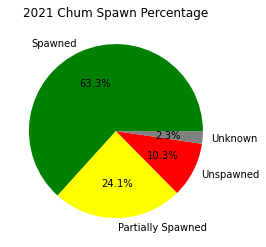

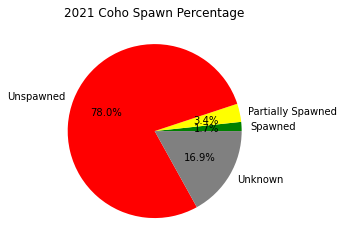

In [105]:
def displaySpawnedChart(salmonDf, species):
    try:
        deadDf = filterSalmonDf(salmonDf, ('Species', species), ('Type', 'Dead'))
        totalDead = deadDf.shape[0]
        totalSpawned = filterSalmonDf(deadDf, ('Spawning_Success', 'Spawned')).shape[0]
        totalPartialSpawned = filterSalmonDf(deadDf, ('Spawning_Success', 'Partially spawned')).shape[0]
        totalUnspawned = filterSalmonDf(deadDf, ('Spawning_Success', 'Unspawned')).shape[0]
        totalUnknownSpawned = filterSalmonDf(deadDf, ('Spawning_Success', 'Unknown')).shape[0]
        spawnPercentages = [totalSpawned/totalDead*100, totalPartialSpawned/totalDead*100, totalUnspawned/totalDead*100, totalUnknownSpawned/totalDead*100]
        colorsList = {'green' : 'Spawned', 'yellow' : 'Partially Spawned', 'red' : 'Unspawned', 'gray' : 'Unknown'}
        pie, ax1 = plt.subplots()
        ax1.pie(spawnPercentages, colors = colorsList, labels=['Spawned', 'Partially Spawned', 'Unspawned', 'Unknown'], autopct='%1.1f%%')
        plt.title(surveyYear + ' ' + species + ' Spawn Percentage')
        addFigureToReport()
        plt.show()
    except ZeroDivisionError:
        print('Unable to display spawned chart. No spawning data to display')
displaySpawnedChart(salmonDf, 'Chum')
displaySpawnedChart(salmonDf, 'Coho')

### Year By Year Count

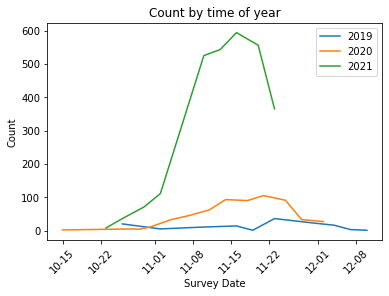

In [106]:
def displayYearByYearCount(surveyURIs, salmonURIs):

#plot each series
    strippedStatsDfs = statsDfs.copy()
    for year in surveyDfs:
        strippedStatsDfs[year]['Survey Date'] = statsDfs[year]['Survey Date'].apply(lambda x: datetime.strptime(x.strftime("%m-%d"), "%m-%d")) 
    fig, ax = plt.subplots()
    plt.plot('Survey Date', 'Total', data=strippedStatsDfs['2019'], label="2019")
    plt.plot('Survey Date', 'Total', data=strippedStatsDfs['2020'], label="2020")
    plt.plot('Survey Date', 'Total', data=strippedStatsDfs['2021'], label="2021")
    plt.title('Count by time of year')
    plt.ylabel('Count')
    plt.xlabel('Survey Date')
    plt.xticks(rotation = 45)
    plt.legend()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    addFigureToReport()
displayYearByYearCount(surveyURIs, salmonURIs)

In [107]:
#Generate HTML report if in google colab
def generateReport():
    if (IN_COLAB):
      from google.colab import files
      files.download(reportFileName)
generateReport()